In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy.spatial import distance
from matplotlib import style 
from collections import defaultdict
style.use('default')

# nltk libraries and sources
import nltk
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /Users/myra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/myra/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/myra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/myra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import sys
sys.path.append('../')
import utils

[nltk_data] Downloading package wordnet to /Users/myra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/myra/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/myra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/myra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data_root_folder = "../data/"
stopwords_en = set(stopwords.words('english'))

# Read Data

### Empathy data set

In [4]:
data_train, data_dev = utils.load_data(data_root_folder)
articles = utils.load_articles()

In [16]:
# lower textual data
data_train['essay'] = data_train['essay'].apply(lambda x: x.lower())
articles['text'] = articles['text'].apply(lambda x: x.lower())

# tokenized version of the text
data_train = utils.tokenize_data(data_train, 'essay')
articles = utils.tokenize_data(articles, 'text')

# word lematizing
data_train = utils.lemmatize_data(data_train, 'essay_tok')
articles = utils.lemmatize_data(articles, 'text_tok')

### Lexical data
#### Empathy and Distress lexicon

\cite{Sedoc2019}

Folders: *data/lexicon/distress* and *data/lexicon/empathy*, all files in there are from that source 

Use lexical data for empathic concern and lexical data for personal distress from http://www.wwbp.org/lexica.html 

In [17]:
# read lexical data
empathy_lex = pd.read_csv(data_root_folder + "lexicon/empathy/empathy_lexicon.txt")
distress_lex = pd.read_csv(data_root_folder + "lexicon/distress/distress_lexicon.txt")

# convert into dictionary
empathy_lex = dict(zip(empathy_lex.word, empathy_lex.rating))
distress_lex = dict(zip(distress_lex.word, distress_lex.rating))

# convert into default dict (if word not in there, it will be 0)
empathy_lex = defaultdict(int, empathy_lex)
distress_lex = defaultdict(int, distress_lex)

#### NRC - Affective Intensity Lexicon: Emotion rating

\cite{Mohammad2018}

folder: *lexicon/NRC-Emotion-Intensity-Lexicon-v1/*

Downloaded here: http://saifmohammad.com/WebPages/AffectIntensity.htm

In [18]:
# load english affective intensity lexicon
AIL_raw_lex  = pd.read_csv(data_root_folder + "lexicon/NRC-Emotion-Intensity-Lexicon-v1/NRC-Emotion-Intensity-Lexicon-v1.txt", sep='\t')
AIL_raw_lex[:3]

,word,emotion,emotion-intensity-score
0,outraged,anger,0.964
1,brutality,anger,0.959
2,hatred,anger,0.953


In [19]:
# pivot data: for each word we have the emotions as columns with their 'emotion-intensity-score'
# Note that the 'emotion-intensity-score' / cells can and will have NaNs
AIL_lex = AIL_raw_lex.pivot(index='word', columns='emotion', values='emotion-intensity-score')
AIL_lex[:3]

emotion,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
word,,,,,,,,
aaaaaaah,NaN,NaN,NaN,0.344,NaN,NaN,NaN,NaN
aaaah,NaN,NaN,NaN,0.234,NaN,NaN,NaN,NaN
abacus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.406


#### NRC - Valence, arousal and dominance

\cite{Mohammad2018b}

Downloaded here: http://saifmohammad.com/WebPages/nrc-vad.html

20.000 words with translations

In [20]:
NRC_VAD_lex = pd.read_csv('../data/lexicon/NRC-VAD-Lexicon-Aug2018Release/NRC-VAD-Lexicon.txt', sep='\t', header=None)
NRC_VAD_lex.columns = ['word', 'valence', 'arousal', 'dominance']
NRC_VAD_lex = NRC_VAD_lex.set_index('word')
NRC_VAD_lex[5:8]

,valence,arousal,dominance
word,,,
abalone,0.500,0.480,0.412
abandon,0.052,0.519,0.245
abandoned,0.046,0.481,0.130


#### Valence, arousal and dominance ratings - Warriner 2013

\cite{Warriner2013}

Filename: *BRM-emot-submit.csv*

Rating of around 14.000 english lemmas (valence, arousal and dominance), might need lemmatization for pre-processign

Data downloaded here: https://link.springer.com/article/10.3758/s13428-012-0314-x#Abs1

In [21]:
VAD_rat = pd.read_csv(data_root_folder + 'lexicon/BRM-emot-submit.csv')
# reduce to only important means of valence, arousal and dominance
VAD_rat_means = VAD_rat[['Word', 'V.Mean.Sum', 'A.Mean.Sum', 'D.Mean.Sum']]
# set words to index
VAD_rat_means.set_index('Word', inplace = True)

# Analysis for feature developement

## ! Word rating scores from lexical data: empathy and distress - Sedoc 2019

Use lexical data for empathic concern and lexical data for personal distress

Changes in feature and the correlation compared to just using average word ratings
* **Removing stop words did not** make the correlation **higher**. (essay_processed = [word for word in essay_tok if not word.lower() in stopwords_en])
* Only **counting high word ratings did not** make the correlation **higher**
* Using **exp function** to make higher rated words more important **make** the correlation **higher**
* **Normalization** (on essay length) **made** the correlation **higher**

|                            | avrg word ratings | count of words with high ratings (> 4) | exp of word ratings | with lemmatizer | exp with tf-idf |
|----------------------------|--------------|----------------------------------|---------------------|---------------------|---------------------|
| empathy - empathy_rating   | 0.416193     | 0.382399                         | **0.456369**            |  0.4440  | 0.453371 |
| distress - distress_rating | 0.445688     | 0.416291                         | **0.468035**            |  0.4667  | 0.443826 |


In [135]:
def emp_dis_calc_word_rating_score(lexicon, essay_tok, normalize=True):
    #Yielded to best results
    #get the word rating for each word and average for the whole essay

    # remove stop words from essay (as they also have ratings for empathy and might not be that important)
    essay_processed = [word for word in essay_tok if not word.lower() in stopwords_en]

    rating_scores = []
    for word in essay_tok:
        rating_scores.append(lexicon[word])

    rating_scores_np = np.array(rating_scores)
    if normalize:
        average_rating = sum(rating_scores_np) / len(rating_scores_np)
        return average_rating
    return sum(rating_scores_np)  # wihtout normalization

def emp_dis_count_high_word_rating_score(lexicon, essay, normalize = True):
    """Count words in essay with high ratings 
    Normalize this with the amount of words in the essay

    Args:
        lexicon (_type_): _description_
        essay (_type_): _description_

    Returns:
        _type_: _description_
    """
    high_rating_words = 0
    for word in essay:
        if lexicon[word] > 4:
            high_rating_words += 1
    if normalize:
        return high_rating_words / len(essay)
    return high_rating_words  # without normalization


# higher word ratings should get higher 'attention'
def emp_dis_calc_exp_word_rating_score(lexicon, essay, normalize = True):
    # using exponential function
    rating_scores = []
    for word in essay:
        rating_scores.append(np.exp(lexicon[word]))

    rating_scores_np = np.array(rating_scores)
    average_rating = sum(rating_scores_np) / len(rating_scores_np)
    if normalize:
        return average_rating
    return sum(rating_scores_np)

In [136]:
emp_dis_data_train = data_train  # data for analysis of empathy and distress lexical data

use_normalization = True  # True or False  whether to use normalization in rating calculation or not
rating_func = emp_dis_calc_exp_word_rating_score

emp_dis_data_train['distress_word_rating'] = emp_dis_data_train.essay_tok.apply(lambda x: rating_func(distress_lex, x, normalize=use_normalization))
emp_dis_data_train['empathy_word_rating'] = emp_dis_data_train.essay_tok.apply(lambda x: rating_func(empathy_lex, x, normalize=use_normalization))

emp_dis_data_train[['distress', 'distress_word_rating']]
emp_dis_data_train[['empathy', 'empathy_word_rating']]

,empathy,empathy_word_rating
0,5.667,48.981805
1,4.833,33.268475
2,5.333,57.560751
3,4.167,32.174292
4,5.333,40.976783
...,...,...
1855,1.000,33.891838
1856,1.000,30.211546
1857,1.000,27.677402
1858,1.000,32.133028


### Correlate Empathy, distress, empathy_word_rating, distress_word_rating
* worked best with using the exp scores

In [137]:
emp_dis_data_train[['empathy', 'distress', 'empathy_word_rating', 'distress_word_rating']].corr()

,empathy,distress,empathy_word_rating,distress_word_rating
empathy,1.000000,0.450938,0.456369,0.255342
distress,0.450938,1.000000,0.288520,0.468035
empathy_word_rating,0.456369,0.288520,1.000000,0.579574
distress_word_rating,0.255342,0.468035,0.579574,1.000000


In [138]:
r, p = pearsonr(emp_dis_data_train['empathy'], emp_dis_data_train['empathy_word_rating'])
print('\n empathy_word_rating and empathy \n r: {:.4f} \n p: {:.8f}'.format(r, p))

r, p = pearsonr(emp_dis_data_train['distress'], emp_dis_data_train['distress_word_rating'])
print('\n distress_word_rating and distress \n r: {:.4f} \n p: {:.8f}'.format(r, p))


 empathy_word_rating and empathy 
 r: 0.4564 
 p: 0.00000000

 distress_word_rating and distress 
 r: 0.4680 
 p: 0.00000000


Text(0.5, 0, 'empathy')

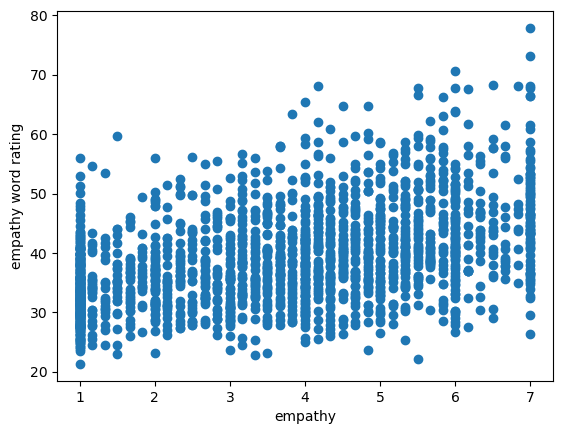

In [139]:
plt.scatter(emp_dis_data_train.empathy, emp_dis_data_train.empathy_word_rating)
plt.ylabel('empathy word rating')
plt.xlabel('empathy')

Text(0.5, 0, 'distress')

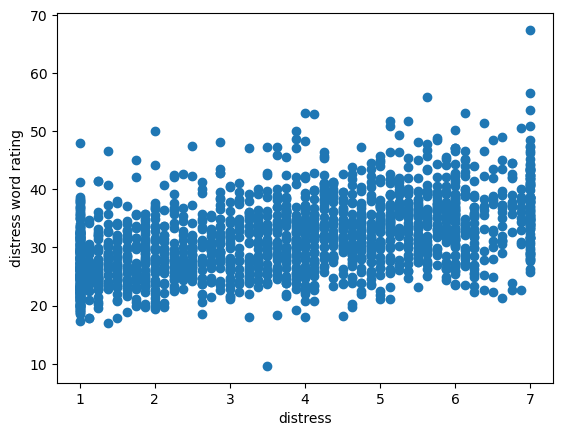

In [140]:
plt.scatter(emp_dis_data_train.distress, emp_dis_data_train.distress_word_rating)
plt.ylabel('distress word rating')
plt.xlabel('distress')

### Do words ratings for empathy and distress in articles correlate with the average empathy / distress associated with this article?

In [141]:
articles_tmp = articles
rating_func = emp_dis_calc_exp_word_rating_score

articles_tmp['art_distress_word_rating'] = articles_tmp.text_tok.apply(lambda x: rating_func(distress_lex, x, normalize=True))
articles_tmp['art_empathy_word_rating'] = articles_tmp.text_tok.apply(lambda x: rating_func(empathy_lex, x, normalize=True))

#articles_tmp[['distress', 'art_distress_word_rating']]
#articles_tmp[['empathy', 'art_empathy_word_rating']]

# join article word rating to training data
emp_dis_joined = emp_dis_data_train.join(articles_tmp.set_index('article_id'), on='article_id', rsuffix='_art')

emp_dis_joined[['empathy', 'art_empathy_word_rating']]
emp_dis_joined[['distress', 'art_distress_word_rating']]

,distress,art_distress_word_rating
0,4.375,35.829074
1,4.875,28.585291
2,3.500,30.143469
3,5.250,28.279579
4,4.625,28.005366
...,...,...
1855,1.000,19.924394
1856,1.000,41.099085
1857,1.000,33.492930
1858,1.000,41.547026


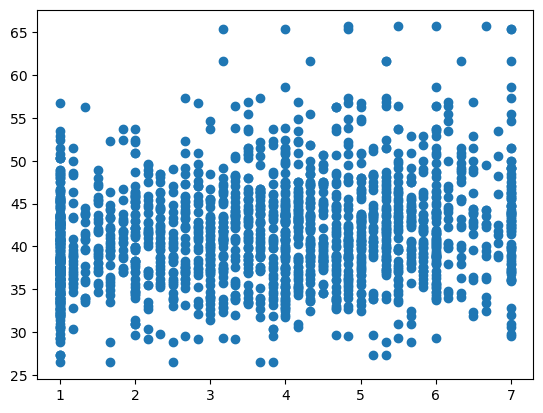

In [142]:
plt.scatter(emp_dis_joined.empathy, emp_dis_joined.art_empathy_word_rating)

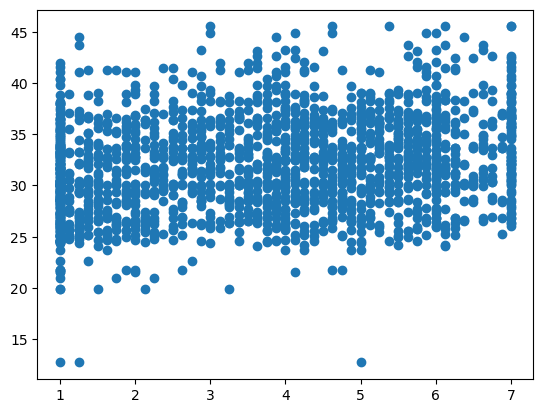

In [143]:
plt.scatter(emp_dis_joined.distress, emp_dis_joined.art_distress_word_rating)

In [144]:
emp_dis_joined[['empathy', 'distress', 'art_empathy_word_rating', 'art_distress_word_rating']].corr()

,empathy,distress,art_empathy_word_rating,art_distress_word_rating
empathy,1.000000,0.450938,0.212138,0.046418
distress,0.450938,1.000000,0.104553,0.240371
art_empathy_word_rating,0.212138,0.104553,1.000000,0.476662
art_distress_word_rating,0.046418,0.240371,0.476662,1.000000


In [145]:
# correlation for distance of article and essay and empathy / distress
emp_dis_joined['empathy_word_rating_dist'] = np.abs(emp_dis_joined['art_empathy_word_rating'] - emp_dis_joined['empathy_word_rating'])
emp_dis_joined['distress_word_rating_dist'] = np.abs(emp_dis_joined['art_distress_word_rating'] - emp_dis_joined['distress_word_rating'])
emp_dis_joined[['empathy', 'distress', 'empathy_word_rating_dist', 'distress_word_rating_dist']].corr()

,empathy,distress,empathy_word_rating_dist,distress_word_rating_dist
empathy,1.000000,0.450938,-0.026937,-0.025047
distress,0.450938,1.000000,-0.074523,0.011293
empathy_word_rating_dist,-0.026937,-0.074523,1.000000,0.373405
distress_word_rating_dist,-0.025047,0.011293,0.373405,1.000000


### TF IDF words to weight ratings
* Did not improve over lexcial data

In [146]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = data_train['essay'].apply(lambda x: ''.join([word for word in x if not word.isdigit()])).tolist()
#corpus = ['This is the first document.','This document is the second document.','And this is the third one.','Is this the first document?', ]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus).toarray()
tfidf_words = vectorizer.get_feature_names_out()
tfidf_words

array(['aah', 'aare', 'abandon', ..., 'zoos', 'zuckermans', 'zulyatu'],
      dtype=object)

In [147]:
tfidf_words_ratings_emp = np.array([empathy_lex[word] for word in tfidf_words])
tfidf_words_ratings_dis= np.array([distress_lex[word] for word in tfidf_words])
tfidf_words_ratings_dis

array([3.03575835, 3.73503386, 4.83920235, ..., 4.75785557, 2.23877081,
       2.23877081])

In [148]:
X_tfidf_words_ratings_emp = X * np.exp(tfidf_words_ratings_emp.reshape(1,-1))  # tf idf of word * ratign of word
X_tfidf_words_ratings_dis = X * np.exp(tfidf_words_ratings_dis.reshape(1,-1))  # tf idf of word * ratign of word
print(X_tfidf_words_ratings_dis.shape)
# take mean of each essay from (1860, 9550) to (1860, )
X_tfidf_words_ratings_emp = X_tfidf_words_ratings_emp.mean(axis=1)
X_tfidf_words_ratings_dis = X_tfidf_words_ratings_dis.mean(axis=1)
print(X_tfidf_words_ratings_dis.shape)

(1860, 9550)
(1860,)


In [149]:
data_train_tfidf = data_train
data_train_tfidf['tfidf_empathy_rating'] = X_tfidf_words_ratings_emp.tolist()
data_train_tfidf['tfidf_distress_rating'] = X_tfidf_words_ratings_dis.tolist()

In [150]:
data_train_tfidf[['empathy', 'distress', 'tfidf_empathy_rating', 'tfidf_distress_rating']].corr()

,empathy,distress,tfidf_empathy_rating,tfidf_distress_rating
empathy,1.000000,0.450938,0.453371,0.248021
distress,0.450938,1.000000,0.283777,0.443826
tfidf_empathy_rating,0.453371,0.283777,1.000000,0.593397
tfidf_distress_rating,0.248021,0.443826,0.593397,1.000000


## NRC - Affective Intensity Lexicon: Emotion rating - Mohammad 2018
* Word lemmatizing with nltk.WordNetLemmatizer could improve correlation of emotion ranking score between essay and article
* Lemmatizer could not improve correlation of similarity art / essay and distress / empathy

In [55]:
AIL_lex[:3]

emotion,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
word,,,,,,,,
aaaaaaah,NaN,NaN,NaN,0.344,NaN,NaN,NaN,NaN
aaaah,NaN,NaN,NaN,0.234,NaN,NaN,NaN,NaN
abacus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.406


In [56]:
# fill na with 0, words are not associated with that emotion, therefore 0 should be fine
AIL_lex = AIL_lex.fillna(0)

### Create emotional vector for the essays based on the affect intensity lexicon

In [57]:
def AIL_create_ave_emotional_vec(essay_tok):
    word_mat = []  # holding emotion vector for each word in essay_tok

    for word in essay_tok:
        if word in AIL_lex.index:
            word_rat = AIL_lex.loc[word]
            word_mat.append(word_rat)
        # no handling if the word is not in the list, just ignore it
        # TODO: Try with zero emotion vector for each emotion
    
    if len(word_mat) <= 0:
        emotion_dict = dict(zip(AIL_lex.columns, np.zeros(len(AIL_lex.columns))))
        series = pd.Series(emotion_dict)
        return series
    word_mat_np = np.array(word_mat)
    # create average emotion vector over all words emotion vectors
    avrg_emotion_vec = word_mat_np.sum(axis=0) / word_mat_np.shape[0]
    norm_emotion_vec = avrg_emotion_vec / avrg_emotion_vec.sum()
    # create data frame from that
    emotion_dict = dict(zip(AIL_lex.columns, norm_emotion_vec))
    series = pd.Series(emotion_dict)
    
    return series


In [58]:
AIL_data_train = data_train

# AIL_data_train[['anger','anticipation','disgust','fear','joy','sadness','surprise','trust']] = AIL_data_train['essay_tok'].apply(lambda x: AIL_create_ave_emotional_vec(x))

AIL_data_train[AIL_lex.columns] = AIL_data_train['essay_tok'].apply(lambda x: AIL_create_ave_emotional_vec(x))
AIL_data_train[:3]

,message_id,response_id,article_id,empathy,distress,empathy_bin,distress_bin,essay,emotion,gender,...,trust,NRC_valence_essay,NRC_arousal_essay,NRC_dominance_essay,valence_rating_essay,arousal_rating_essay,dominance_rating_essay,count_I,count_WE,I_WE_ratio
0,R_1hGrPtWM4SumG0U_1,R_1hGrPtWM4SumG0U,67,5.667,4.375,1,1,it is really diheartening to read about these ...,sadness,1,...,0.085249,1.774221,1.748767,1.689770,315.609325,102.776839,220.688296,0.0,0.000000,0.0
1,R_1hGrPtWM4SumG0U_2,R_1hGrPtWM4SumG0U,86,4.833,4.875,1,1,the phone lines from the suicide prevention li...,sadness,1,...,0.150636,1.815987,1.571639,1.641031,289.398447,70.580962,248.604151,0.0,0.018519,0.0
2,R_1hGrPtWM4SumG0U_3,R_1hGrPtWM4SumG0U,206,5.333,3.500,1,0,"no matter what your heritage, you should be ab...",neutral,1,...,0.697715,1.910596,1.582854,1.834783,470.845331,70.072895,324.995800,0.0,0.000000,0.0


In [59]:
AIL_data_train[['empathy', 'distress', 'anger','anticipation','disgust','fear','joy','sadness','surprise','trust']].corr()

,empathy,distress,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
empathy,1.000000,0.450938,-0.031797,-0.031150,-0.041619,0.032804,0.067904,0.129018,-0.114458,-0.067968
distress,0.450938,1.000000,0.112494,-0.074416,0.057218,0.131420,-0.104938,0.101014,-0.112593,-0.102990
anger,-0.031797,0.112494,1.000000,-0.404076,0.260181,0.296004,-0.455089,0.087028,-0.125221,-0.378451
anticipation,-0.031150,-0.074416,-0.404076,1.000000,-0.257467,-0.400177,0.292755,-0.334910,0.012329,0.112321
disgust,-0.041619,0.057218,0.260181,-0.257467,1.000000,0.048191,-0.321997,0.101965,-0.121909,-0.323767
fear,0.032804,0.131420,0.296004,-0.400177,0.048191,1.000000,-0.510786,0.215959,-0.164680,-0.461058
joy,0.067904,-0.104938,-0.455089,0.292755,-0.321997,-0.510786,1.000000,-0.324752,-0.007798,0.163822
sadness,0.129018,0.101014,0.087028,-0.334910,0.101965,0.215959,-0.324752,1.000000,-0.175732,-0.488131
surprise,-0.114458,-0.112593,-0.125221,0.012329,-0.121909,-0.164680,-0.007798,-0.175732,1.000000,-0.053571
trust,-0.067968,-0.102990,-0.378451,0.112321,-0.323767,-0.461058,0.163822,-0.488131,-0.053571,1.000000


### Correlation of essay and article emotions

There is a weak correlation between the emotions in the article and the essay. 
* between -0.232557 (fear - joy_art) and 0.352686 (anger - anger_art)

In [60]:
articles_tmp = articles
rating_func = AIL_create_ave_emotional_vec

articles_tmp[AIL_lex.columns] = articles_tmp.text_tok.apply(lambda x: rating_func(x))

# join article word rating to training data
AIL_joined = AIL_data_train.join(articles_tmp.set_index('article_id'), on='article_id', rsuffix='_art')

#### ! Correlate emotions in essay and article based on affect intensity

In [61]:
corr_table = AIL_joined[['anger_art','anticipation_art','disgust_art', 'fear_art','joy_art','sadness_art','surprise_art','trust_art','anger','anticipation','disgust','fear','joy','sadness','surprise','trust']].corr()
corr_table.where(np.abs(corr_table) > 0.1, '--')

,anger_art,anticipation_art,disgust_art,fear_art,joy_art,sadness_art,surprise_art,trust_art,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
anger_art,1.0,-0.503449,0.115178,0.425066,-0.488125,--,--,-0.472536,0.410382,-0.180182,--,0.182302,-0.22167,--,--,-0.129127
anticipation_art,-0.503449,1.0,-0.11923,-0.537338,0.393641,-0.424987,-0.109025,0.252172,-0.246297,0.264131,--,-0.222332,0.196844,-0.12268,--,0.131396
disgust_art,0.115178,-0.11923,1.0,--,-0.21932,0.206071,-0.107259,-0.329518,--,--,0.24526,--,--,--,--,--
fear_art,0.425066,-0.537338,--,1.0,-0.60388,0.31191,--,-0.539339,0.193891,-0.16539,--,0.384761,-0.20964,0.134042,--,-0.246739
joy_art,-0.488125,0.393641,-0.21932,-0.60388,1.0,-0.331104,-0.110874,0.225509,-0.195265,0.168357,--,-0.272058,0.288752,--,--,0.102737
sadness_art,--,-0.424987,0.206071,0.31191,-0.331104,1.0,--,-0.503966,--,-0.10925,--,0.106521,--,0.281551,--,-0.194206
surprise_art,--,-0.109025,-0.107259,--,-0.110874,--,1.0,-0.174859,--,--,--,--,--,--,0.304083,--
trust_art,-0.472536,0.252172,-0.329518,-0.539339,0.225509,-0.503966,-0.174859,1.0,-0.182831,0.124293,--,-0.185803,--,-0.172182,--,0.28907
anger,0.410382,-0.246297,--,0.193891,-0.195265,--,--,-0.182831,1.0,-0.404076,0.260181,0.296004,-0.455089,--,-0.125221,-0.378451
anticipation,-0.180182,0.264131,--,-0.16539,0.168357,-0.10925,--,0.124293,-0.404076,1.0,-0.257467,-0.400177,0.292755,-0.33491,--,0.112321


In [65]:
for col in AIL_lex.columns:  # all emotions
    # calc distance of emotion from essay and article
    AIL_joined[col + '_sim'] = AIL_joined[col] - AIL_joined[col + '_art']
    #AIL_joined[col + '_sim'] = AIL_joined[col + '_sim'].apply(lambda x: np.linalg.norm(x))

    

In [66]:

def euclid_dist_emotion_vec(row):
    emo_cols_essay = sorted([col for col in row.index if not '_art' in col])
    emo_cols_art = sorted([col for col in row.index if '_art' in col])

    emo_essay = np.array(list(map(lambda x: row[x], emo_cols_essay)))
    emo_art = np.array(list(map(lambda x: row[x], emo_cols_art)))
    euclid_dist = np.linalg.norm(emo_essay-emo_art)
    return euclid_dist
    

# calc euclidean distance of emotional vectors
AIL_joined['emotion_euclid_dist'] = AIL_joined[list(AIL_lex.columns) + [col + '_art' for col in AIL_lex.columns]].apply(euclid_dist_emotion_vec, axis=1)


In [67]:
AIL_joined[['empathy', 'distress', 'emotion_euclid_dist']].corr()

,empathy,distress,emotion_euclid_dist
empathy,1.000000,0.450938,-0.048544
distress,0.450938,1.000000,-0.102346
emotion_euclid_dist,-0.048544,-0.102346,1.000000


### Correlation of similarity of emotions in article and essay

In [68]:
AIL_joined[[col + '_sim' for col in AIL_lex.columns] + ['empathy', 'distress']].corr()

,anger_sim,anticipation_sim,disgust_sim,fear_sim,joy_sim,sadness_sim,surprise_sim,trust_sim,empathy,distress
anger_sim,1.000000,-0.350092,0.266917,0.259956,-0.401383,0.092857,-0.099791,-0.395004,0.012868,0.040391
anticipation_sim,-0.350092,1.000000,-0.220151,-0.380304,0.207565,-0.334896,0.036423,0.050409,-0.022639,-0.019639
disgust_sim,0.266917,-0.220151,1.000000,0.034407,-0.299255,0.113332,-0.093359,-0.362499,-0.041160,0.028130
fear_sim,0.259956,-0.380304,0.034407,1.000000,-0.463097,0.188694,-0.137441,-0.414654,-0.002918,0.052713
joy_sim,-0.401383,0.207565,-0.299255,-0.463097,1.000000,-0.345963,-0.050244,0.130946,0.068120,-0.018051
sadness_sim,0.092857,-0.334896,0.113332,0.188694,-0.345963,1.000000,-0.138465,-0.439782,0.078532,0.059045
surprise_sim,-0.099791,0.036423,-0.093359,-0.137441,-0.050244,-0.138465,1.000000,-0.118422,-0.078389,-0.086890
trust_sim,-0.395004,0.050409,-0.362499,-0.414654,0.130946,-0.439782,-0.118422,1.000000,-0.047354,-0.056434
empathy,0.012868,-0.022639,-0.041160,-0.002918,0.068120,0.078532,-0.078389,-0.047354,1.000000,0.450938
distress,0.040391,-0.019639,0.028130,0.052713,-0.018051,0.059045,-0.086890,-0.056434,0.450938,1.000000


## NRC - Valence, arousal and dominance - Mohammad 2018b

#### Correlate rating for VAD ratings of essay and article
Correlation because texts and words are similar?


|                            | valence_rating_essay | arousal_rating_essay | dominance_rating_essay |
|----------------------------|--------------|----------------------------------|---------------------|
| valence_rating_article       | 0.30459	     | -0.173700		                        | 0.089979           |
| arousal_rating_article      | -0.191863		      | 0.326280		                         | 0.089315	          |
| dominance_rating_article    | -0.017146		       | 0.093659		                       | 0.271484	         |

##### With lemmatization for essay and article

|                            | valence_rating_essay | arousal_rating_essay | dominance_rating_essay |
|----------------------------|--------------|----------------------------------|---------------------|
| valence_rating_article       | 0.329492	     | -0.215537		                        | 0.080460	           |
| arousal_rating_article      | -0.200223		      | 0.356457			                         | 0.102810	          |
| dominance_rating_article    | -0.011758		       | 0.097096		                       | 0.295923		         |

In [27]:
NRC_VAD_lex[5:8]

,valence,arousal,dominance
word,,,
abalone,0.500,0.480,0.412
abandon,0.052,0.519,0.245
abandoned,0.046,0.481,0.130


In [28]:
NRC_VAD_data_train = data_train

In [35]:
def arvg_sent_rating_NRC_VAD(essay_tok, column_name):
    #Yielded to best results
    #get the word rating for each word and average for the whole essay

    # remove stop words from essay (as they also have ratings for empathy and might not be that important)
    essay_processed = [word for word in essay_tok if not word.lower() in stopwords_en]

    word_ratings = []
    for word in essay_tok:
        word = word.lower()
        if word in NRC_VAD_lex.index:
            word_rat = NRC_VAD_lex.loc[word]
            word_ratings.append(np.exp(word_rat[column_name]))

    word_ratings_np = np.array(word_ratings).astype(float)

    if len(word_ratings_np) > 0:  # list should all have the same length
        word_ratings_np = sum(word_ratings_np) / len(word_ratings_np)
        return word_ratings_np
    return 0

In [36]:
NRC_VAD_data_train['NRC_valence_essay'] = NRC_VAD_data_train.essay_tok_lem.apply(lambda x: arvg_sent_rating_NRC_VAD(x, 'valence'))
NRC_VAD_data_train['NRC_arousal_essay'] = NRC_VAD_data_train.essay_tok_lem.apply(lambda x: arvg_sent_rating_NRC_VAD(x, 'arousal'))
NRC_VAD_data_train['NRC_dominance_essay'] = NRC_VAD_data_train.essay_tok_lem.apply(lambda x: arvg_sent_rating_NRC_VAD(x, 'dominance'))
NRC_VAD_data_train[:3]

,message_id,response_id,article_id,empathy,distress,empathy_bin,distress_bin,essay,emotion,gender,...,iri_fantasy,iri_empathatic_concern,essay_tok,valence_rating_essay,arousal_rating_essay,dominance_rating_essay,essay_tok_lem,NRC_valence_essay,NRC_arousal_essay,NRC_dominance_essay
0,R_1hGrPtWM4SumG0U_1,R_1hGrPtWM4SumG0U,67,5.667,4.375,1,1,it is really diheartening to read about these ...,sadness,1,...,3.429,4.0,"[it, is, really, diheartening, to, read, about...",315.609325,102.776839,220.688296,"[it, is, really, diheartening, to, read, about...",1.812264,1.739158,1.703211
1,R_1hGrPtWM4SumG0U_2,R_1hGrPtWM4SumG0U,86,4.833,4.875,1,1,the phone lines from the suicide prevention li...,sadness,1,...,3.429,4.0,"[the, phone, lines, from, the, suicide, preven...",289.398447,70.580962,248.604151,"[the, phone, line, from, the, suicide, prevent...",1.819478,1.558747,1.631826
2,R_1hGrPtWM4SumG0U_3,R_1hGrPtWM4SumG0U,206,5.333,3.500,1,0,"no matter what your heritage, you should be ab...",neutral,1,...,3.429,4.0,"[no, matter, what, your, heritage, ,, you, sho...",470.845331,70.072895,324.995800,"[no, matter, what, your, heritage, ,, you, sho...",1.913832,1.579261,1.828995


In [40]:
NRC_VAD_articles = articles
NRC_VAD_articles['NRC_valence_art'] = NRC_VAD_articles.text_tok_lem.apply(lambda x: arvg_sent_rating_NRC_VAD(x, 'valence'))
NRC_VAD_articles['NRC_arousal_art'] = NRC_VAD_articles.text_tok_lem.apply(lambda x: arvg_sent_rating_NRC_VAD(x, 'arousal'))
NRC_VAD_articles['NRC_dominance_art'] = NRC_VAD_articles.text_tok_lem.apply(lambda x: arvg_sent_rating_NRC_VAD(x, 'dominance'))
NRC_VAD_articles[:3]

,article_id,text,text_tok,valence_rating_article,arousal_rating_article,dominance_rating_article,text_tok_lem,NRC_valence_art,NRC_arousal_art,NRC_dominance_art
0,1,'abhorrent' bottle attack on young rangers fan...,"['abhorrent, ', bottle, attack, on, young, ran...",385.945333,135.019339,338.068378,"['abhorrent, ', bottle, attack, on, young, ran...",1.794883,1.668602,1.749775
1,2,'afghan girl' in iconic national geographic ph...,"['afghan, girl, ', in, iconic, national, geogr...",389.467968,92.194184,324.326887,"['afghan, girl, ', in, iconic, national, geogr...",1.796700,1.617570,1.786508
2,3,'my whole family has been wiped out': victims ...,"['my, whole, family, has, been, wiped, out, ',...",500.478441,123.923845,302.141441,"['my, whole, family, ha, been, wiped, out, ', ...",1.830318,1.601136,1.694637


In [41]:
NRC_VAD_joined = NRC_VAD_data_train.join(NRC_VAD_articles.set_index('article_id'), on='article_id', rsuffix='_art')
NRC_VAD_joined[:3]

,message_id,response_id,article_id,empathy,distress,empathy_bin,distress_bin,essay,emotion,gender,...,NRC_dominance_essay,text,text_tok,valence_rating_article,arousal_rating_article,dominance_rating_article,text_tok_lem,NRC_valence_art,NRC_arousal_art,NRC_dominance_art
0,R_1hGrPtWM4SumG0U_1,R_1hGrPtWM4SumG0U,67,5.667,4.375,1,1,it is really diheartening to read about these ...,sadness,1,...,1.703211,at least 239 migrants believed drowned in medi...,"[at, least, 239, migrants, believed, drowned, ...",364.889226,83.401958,296.330334,"[at, least, 239, migrant, believed, drowned, i...",1.790333,1.627684,1.732991
1,R_1hGrPtWM4SumG0U_2,R_1hGrPtWM4SumG0U,86,4.833,4.875,1,1,the phone lines from the suicide prevention li...,sadness,1,...,1.631826,calls to crisis and suicide prevention hotline...,"[calls, to, crisis, and, suicide, prevention, ...",402.902118,114.684676,357.418956,"[call, to, crisis, and, suicide, prevention, h...",1.818103,1.654114,1.733616
2,R_1hGrPtWM4SumG0U_3,R_1hGrPtWM4SumG0U,206,5.333,3.500,1,0,"no matter what your heritage, you should be ab...",neutral,1,...,1.828995,mark kirk apologizes for using tammy duckworth...,"[mark, kirk, apologizes, for, using, tammy, du...",483.061639,128.310485,320.095247,"[mark, kirk, apologizes, for, using, tammy, du...",1.806022,1.672449,1.837738


### ! Correlate NRC valence, arousal and dominance for essay, empahty and article
Maybe they just correlate because the words corrlate?
* Lemmatizing improves correlation of VAD art and VAD essay. Also interestingly *NRC_Arousal_art* and *empathy* as well as *NRC_dominance_art* and *empathy* have a weak, negative correlaion (-0.105 for both)

In [43]:
corr_table = NRC_VAD_joined[['empathy', 'distress', 'NRC_valence_essay', 'NRC_arousal_essay', 'NRC_dominance_essay', 'NRC_valence_art', 'NRC_arousal_art', 'NRC_dominance_art']].corr()
corr_table.where(np.abs(corr_table) >= 0.1, '-')

,empathy,distress,NRC_valence_essay,NRC_arousal_essay,NRC_dominance_essay,NRC_valence_art,NRC_arousal_art,NRC_dominance_art
empathy,1.0,0.450938,-,-,-,-,-0.105415,-0.104516
distress,0.450938,1.0,-0.110402,-,-,-0.132588,-,-
NRC_valence_essay,-,-0.110402,1.0,-0.187856,0.491405,0.329492,-0.200223,-
NRC_arousal_essay,-,-,-0.187856,1.0,0.408237,-0.215537,0.356457,-
NRC_dominance_essay,-,-,0.491405,0.408237,1.0,-,0.10281,0.295923
NRC_valence_art,-,-0.132588,0.329492,-0.215537,-,1.0,-0.50179,0.173706
NRC_arousal_art,-0.105415,-,-0.200223,0.356457,0.10281,-0.50179,1.0,0.405593
NRC_dominance_art,-0.104516,-,-,-,0.295923,0.173706,0.405593,1.0


#### Does the correlation / difference of Art and Essay in VAD correlate with empathy or distress?

Would mean that the article has influence on the answer, might also just means that the essay uses similar words like in article.

- Correlation is low: Highest was 0.057563 of empathy and valence_sim


In [82]:
NRC_VAD_joined['NRC_valence_sim'] = NRC_VAD_joined[['NRC_valence_essay', 'NRC_valence_art']].apply(lambda x: np.abs(x[0] - x[1]), axis=1)
NRC_VAD_joined['NRC_arousal_sim'] = NRC_VAD_joined[['NRC_arousal_essay', 'NRC_arousal_art']].apply(lambda x: np.abs(x[0] - x[1]), axis=1)
NRC_VAD_joined['NRC_dominance_sim'] = NRC_VAD_joined[['NRC_dominance_essay', 'NRC_dominance_art']].apply(lambda x: np.abs(x[0] - x[1]), axis=1)
#NRC_VAD_joined['NRC_arousal_sim'] = NRC_VAD_articles.text_tok.apply(lambda x: arvg_sent_rating_NRC_VAD(x, 'arousal'))
#NRC_VAD_joined['NRC_dominance_sim'] = NRC_VAD_articles.text_tok.apply(lambda x: arvg_sent_rating_NRC_VAD(x, 'dominance'))
NRC_VAD_joined[:3]

,message_id,response_id,article_id,empathy,distress,empathy_bin,distress_bin,essay,emotion,gender,...,trust_art,NRC_valence_art,NRC_arousal_art,NRC_dominance_art,valence_rating_article,arousal_rating_article,dominance_rating_article,NRC_valence_sim,NRC_arousal_sim,NRC_dominance_sim
0,R_1hGrPtWM4SumG0U_1,R_1hGrPtWM4SumG0U,67,5.667,4.375,1,1,it is really diheartening to read about these ...,sadness,1,...,0.206069,1.790333,1.627684,1.732991,364.889226,83.401958,296.330334,0.021931,0.111474,0.029780
1,R_1hGrPtWM4SumG0U_2,R_1hGrPtWM4SumG0U,86,4.833,4.875,1,1,the phone lines from the suicide prevention li...,sadness,1,...,0.147656,1.818103,1.654114,1.733616,402.902118,114.684676,357.418956,0.001375,0.095367,0.101790
2,R_1hGrPtWM4SumG0U_3,R_1hGrPtWM4SumG0U,206,5.333,3.500,1,0,"no matter what your heritage, you should be ab...",neutral,1,...,0.275725,1.806022,1.672449,1.837738,483.061639,128.310485,320.095247,0.107810,0.093188,0.008743


In [83]:
corr_table = NRC_VAD_joined[['empathy', 'distress', 'NRC_valence_sim', 'NRC_arousal_sim', 'NRC_dominance_sim']].corr()
corr_table.where(np.abs(corr_table) >= 0, '-')

,empathy,distress,NRC_valence_sim,NRC_arousal_sim,NRC_dominance_sim
empathy,1.000000,0.450938,0.054751,-0.015425,-0.015119
distress,0.450938,1.000000,0.015856,0.000078,0.007955
NRC_valence_sim,0.054751,0.015856,1.000000,0.464557,0.374219
NRC_arousal_sim,-0.015425,0.000078,0.464557,1.000000,0.460309
NRC_dominance_sim,-0.015119,0.007955,0.374219,0.460309,1.000000


## ! VAD - Word ratings ratings: lexicon for valence, arousal and dominance - Warriner 2013
### Correlate rating for VAD ratings of essay and article and empathy / distress
\cite{Warriner2013}

Data downloaded here:
https://link.springer.com/article/10.3758/s13428-012-0314-x#Abs1

Using the means from the data for each word.

##### Correlate rating for VAD ratings of essay and article
|                            | valence_rating_essay | arousal_rating_essay | dominance_rating_essay |
|----------------------------|--------------|----------------------------------|---------------------|
| valence_rating_article       | 0.260087	     | -0.103182	                        | 0.208841           |
| arousal_rating_article      | -0.117479	      | 0.296888	                         | -0.128977          |
| dominance_rating_article    | 0.233890	       | -0.122517	                       | 0.260270          |


With exp means from the data
|                            | valence_rating_essay | arousal_rating_essay | dominance_rating_essay |
|----------------------------|--------------|----------------------------------|---------------------|
| valence_rating_article       | 0.260087     | -0.083720                        | 0.143390           |
| arousal_rating_article      | -0.062837	      | 0.373930	                         | -0.121513          |
| dominance_rating_article    | 0.176424	       | -0.143986	                       | 0.214861          |

##### Correlate rating for VAD ratings empathy / distress
The correlation is weak: Between -0.134084 and 0.107825.


In [22]:
# look at data
VAD_rat_means[:5]

,V.Mean.Sum,A.Mean.Sum,D.Mean.Sum
Word,,,
aardvark,6.26,2.41,4.27
abalone,5.30,2.65,4.95
abandon,2.84,3.73,3.32
abandonment,2.63,4.95,2.64
abbey,5.85,2.20,5.00


In [23]:
def calc_avrg_word_affective_rating_score(essay_tok, column_name):
    #Yielded to best results
    #get the word rating for each word and average for the whole essay

    # remove stop words from essay (as they also have ratings for empathy and might not be that important)
    essay_processed = [word for word in essay_tok if not word.lower() in stopwords_en]

    rating_column_name = []
    for word in essay_tok:
        word = word.lower()
        if word in VAD_rat_means.index:
            word_rat = VAD_rat_means.loc[word]
            rating_column_name.append(np.exp(word_rat[column_name]))

    rating_column_name_np = np.array(rating_column_name).astype(float)

    if len(rating_column_name_np) > 0:  # list should all have the same length
        rating_column_name_np = sum(rating_column_name_np) / len(rating_column_name_np)
        return rating_column_name_np
    return 0

In [24]:
VAD_tmp = data_train

use_normalization = True  # True or False  whether to use normalization in rating calculation or not
rating_func = calc_avrg_word_affective_rating_score

VAD_tmp['valence_rating_essay'] = VAD_tmp.essay_tok.apply(lambda x: calc_avrg_word_affective_rating_score(x, 'V.Mean.Sum'))
VAD_tmp['arousal_rating_essay'] = VAD_tmp.essay_tok.apply(lambda x: calc_avrg_word_affective_rating_score(x, 'A.Mean.Sum'))
VAD_tmp['dominance_rating_essay'] = VAD_tmp.essay_tok.apply(lambda x: calc_avrg_word_affective_rating_score(x, 'D.Mean.Sum'))

# ratings for articles
articles_tmp = articles
articles_tmp['valence_rating_article'] = articles_tmp.text_tok.apply(lambda x: calc_avrg_word_affective_rating_score(x, 'V.Mean.Sum'))
articles_tmp['arousal_rating_article'] = articles_tmp.text_tok.apply(lambda x: calc_avrg_word_affective_rating_score(x, 'A.Mean.Sum'))
articles_tmp['dominance_rating_article'] = articles_tmp.text_tok.apply(lambda x: calc_avrg_word_affective_rating_score(x, 'D.Mean.Sum'))

In [25]:
# join on article id
VAD_joined = VAD_tmp.join(articles_tmp.set_index('article_id'), on='article_id', rsuffix='_art')

VAD_joined[['valence_rating_essay', 'arousal_rating_essay', 'dominance_rating_essay', 'empathy', 'distress', 'valence_rating_article', 'arousal_rating_article', 'dominance_rating_article']]

,valence_rating_essay,arousal_rating_essay,dominance_rating_essay,empathy,distress,valence_rating_article,arousal_rating_article,dominance_rating_article
0,315.609325,102.776839,220.688296,5.667,4.375,364.889226,83.401958,296.330334
1,289.398447,70.580962,248.604151,4.833,4.875,402.902118,114.684676,357.418956
2,470.845331,70.072895,324.995800,5.333,3.500,483.061639,128.310485,320.095247
3,632.023508,110.274086,399.778626,4.167,5.250,417.614819,112.757899,246.270959
4,714.819538,62.475238,393.158054,5.333,4.625,539.162673,94.716931,333.135494
...,...,...,...,...,...,...,...,...
1855,964.861545,109.657418,481.929287,1.000,1.000,622.947501,116.890996,401.267926
1856,346.311283,209.615860,342.711412,1.000,1.000,332.858839,97.846008,270.465959
1857,412.588968,106.432519,335.016729,1.000,1.000,234.463231,113.369519,231.039775
1858,582.143609,136.568294,297.865763,1.000,1.000,473.015385,119.696186,296.490739


* Lemmatizing improved correlation between VAD essay and article but about the same for correlation of empathy / distress and VAD rating 

In [26]:
corr_table = VAD_joined[['valence_rating_essay', 'arousal_rating_essay', 'dominance_rating_essay', 'empathy', 'distress', 'valence_rating_article', 'arousal_rating_article', 'dominance_rating_article']].corr()
corr_table.where(np.abs(corr_table) >= 0.1, '-')

,valence_rating_essay,arousal_rating_essay,dominance_rating_essay,empathy,distress,valence_rating_article,arousal_rating_article,dominance_rating_article
valence_rating_essay,1.0,-,0.616074,-,-,0.260087,-,0.176424
arousal_rating_essay,-,1.0,-0.224797,-,0.107825,-,0.37393,-0.143986
dominance_rating_essay,0.616074,-0.224797,1.0,-,-0.134084,0.14339,-0.121513,0.214861
empathy,-,-,-,1.0,0.450938,-,-,-
distress,-,0.107825,-0.134084,0.450938,1.0,-0.124245,-,-0.104998
valence_rating_article,0.260087,-,0.14339,-,-0.124245,1.0,-0.163409,0.612068
arousal_rating_article,-,0.37393,-0.121513,-,-,-0.163409,1.0,-0.289597
dominance_rating_article,0.176424,-0.143986,0.214861,-,-0.104998,0.612068,-0.289597,1.0


# IRI
## Count I vs We in text for IRI prediction (perspective taking) 
Called Integrative complexity \cite{Zhou2021}

There are alread models mesaureing integrative complexity \cite{Zhou2021}

Usage of I vs we:
* Very weak correlation, but the correlation of I count is higher with perspective taking (0.060223) than we count (0.019808).
* For ratio (counts of: I / I+WE), there is a very weak correlation of perspective taking (0.072816) and empathetic concern (0.089739)

In [47]:
IRI_joined = data_train

In [48]:
def count_word(target_word, text, normalize=True):
    counter = 0
    text = [tok.lower() for tok in text]
    target_word = target_word.lower()
    for word in text:
        if word == target_word:
            counter += 1
    if normalize:
        counter = counter / len(text)
    return counter

def I_we_ratio(text):
    count_I = 0
    count_we = 0
    text = [tok.lower() for tok in text]
    for word in text:
        if word == 'i':
            count_I += 1
        if word == 'we':
            count_we += 1

    ratio = 0  # default case
    if (count_we + count_I) > 0:
        ratio = count_I / (count_we + count_I)
    return ratio


IRI_joined["count_I"] = IRI_joined.essay_tok.apply(lambda x: count_word('i', x))
IRI_joined["count_WE"] = IRI_joined.essay_tok.apply(lambda x: count_word('we', x))
IRI_joined["I_WE_ratio"] = IRI_joined.essay_tok.apply(lambda x: I_we_ratio(x))

tmp_corr_table = IRI_joined[['empathy', 'distress', 'I_WE_ratio', 'count_I', 'count_WE', 'iri_perspective_taking', 'iri_personal_distress', 'iri_fantasy', 'iri_empathatic_concern']].corr()
tmp_corr_table

,empathy,distress,I_WE_ratio,count_I,count_WE,iri_perspective_taking,iri_personal_distress,iri_fantasy,iri_empathatic_concern
empathy,1.000000,0.450938,-0.033966,-0.066780,0.031256,0.228567,0.005806,0.161712,0.299363
distress,0.450938,1.000000,-0.088099,-0.137199,0.103226,0.126524,0.189525,0.120541,0.198645
I_WE_ratio,-0.033966,-0.088099,1.000000,0.648833,-0.392549,0.072816,0.007723,0.037720,0.089739
count_I,-0.066780,-0.137199,0.648833,1.000000,-0.118291,0.060223,0.012725,0.010720,0.049696
count_WE,0.031256,0.103226,-0.392549,-0.118291,1.000000,0.019808,-0.020046,0.012781,0.024511
iri_perspective_taking,0.228567,0.126524,0.072816,0.060223,0.019808,1.000000,-0.176414,0.307912,0.665747
iri_personal_distress,0.005806,0.189525,0.007723,0.012725,-0.020046,-0.176414,1.000000,0.130182,-0.041496
iri_fantasy,0.161712,0.120541,0.037720,0.010720,0.012781,0.307912,0.130182,1.000000,0.443645
iri_empathatic_concern,0.299363,0.198645,0.089739,0.049696,0.024511,0.665747,-0.041496,0.443645,1.000000
